
# Clustered Multitask QEP (w/ Pyro/QPyTorch High-Level Interface)

## Introduction

In this example, we use the Pyro integration for a QEP model with additional latent variables.

We are modelling a multitask QEP in this example. Rather than assuming a linear correlation among the different tasks, we assume that there is cluster structure for the different tasks. Let's assume there are $k$ different clusters of tasks. The generative model for task $i$ is:

$$
p(\mathbf y_i \mid \mathbf x_i) = \int \sum_{z_i=1}^k p(\mathbf y_i \mid \mathbf f (\mathbf x_i), z_i) \: p(z_i) \: p(\mathbf f (\mathbf x_i) ) \: d \mathbf f
$$

where $z_i$ is the cluster assignment for task $i$. There are therefore $k$ latent functions $\mathbf f = [f_1 \ldots f_k]$, each modelled by a QEP, representing each cluster.

Our goal is therefore to infer:

- The latent functions $f_1 \ldots f_k$
- The cluster assignments $z_i$ for each task

In [2]:
import math
import torch
import pyro
import tqdm
import qpytorch
from matplotlib import pyplot as plt

%matplotlib inline
import matplotlib as mpl
mpl.rc_file_defaults()

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)

## Adding additional latent variables to the likelihood

The standard QPyTorch variational objects will take care of inferring the latent functions $f_1 \ldots f_k$. However, we do need to add the additional latent variables $z_i$ to the models. We will do so by creating a custom likelihood that models:

$$
\sum_{z_i=1}^k p(\mathbf y_i \mid \mathbf f (\mathbf x_i), z_i) \: p(z_i)
$$

QPyTorch's likelihoods are capable of modeling additional latent variables. Our custom likelihood needs to define the following three functions:

- `pyro_model` (needs to call through to `super().pyro_model` at the end), which defines the prior distribution for additional latent variables
- `pyro_guide` (needs to call through to `super().pyro_guide` at the end), which defines the variational (guide) distribution for additional latent variables
- `forward`, which defines the observation distributions conditioned on $\mathbf f (\mathbf x_i)$ and any additional latent variables.

### The pyro_model function

For each task, we will model the cluster assignment with a `OneHotCategorical` variable, where each cluster has equal probability. The `pyro_model` function will make a `pyro.sample` call to this prior distribution and then call the super method:

```python
    # self.prior_cluster_logits = torch.zeros(num_tasks, num_clusters)

    def pyro_model(self, function_dist, target):
        cluster_assignment_samples = pyro.sample(
            self.name_prefix + ".cluster_logits",  # self.name_prefix is added by PyroQEP
            pyro.distributions.OneHotCategorical(logits=self.prior_cluster_logits).to_event(1)
        )
        return super().pyro_model(
            function_dist,
            target,
            cluster_assignment_samples=cluster_assignment_samples
        )
```

Note that we are adding an additional argument `cluster_assignment_samples` to the `super().pyro_model` call. This will pass the cluster assignment samples to the `forward` call, which is necessary for inference.

### The pyro_guide function

For each task, the variational (guide) diustribution will also be a `OneHotCategorical` variable, which will be defined by the parameter `self.variational_cluster_logits`. The `pyro_guide` function will make a `pyro.sample` call to this prior distribution and then call the super method:

```python
    def pyro_guide(self, function_dist, target):
        pyro.sample(
            self.name_prefix + ".cluster_logits",  # self.name_prefix is added by PyroQEP
            pyro.distributions.OneHotCategorical(logits=self.variational_cluster_logits).to_event(1)
        )
        return super().pyro_guide(function_dist, target)
```

Note that we are adding an additional argument `cluster_assignment_samples` to the `super().pyro_model` call. This will pass the cluster assignment samples to the `forward` call, which is necessary for inference.


### The forward function

The `pyro_model` fuction passes the additional keyword argument `cluster_assignment_samples` to the `forward` call. Therefore, our forward method will define the conditional probability $p(\mathbf y_i \mid \mathbf f(\mathbf x), z_i)$, where $\mathbf f(\mathbf x)$ corresponds to the variable `function_samples` and $z_i$ corresponds to the variable `cluster_assignment_samples`.

In our example $p(\mathbf y_i \mid \mathbf f(\mathbf x), z_i)$ corresponds to a Gaussian noise model.

```python
    # self.raw_noise is the Gaussian noise parameter
    # function_samples is `n x k`
    # cluster_assignment_samples is `k x t`, where `t` is the number of tasks

    def forward(self, function_samples, cluster_assignment_samples):
        return pyro.distributions.Normal(
            loc=(function_samples.unsqueeze(-2) * cluster_assignment_samples).sum(-1),
            scale=torch.nn.functional.softplus(self.raw_noise).sqrt()
        ).to_event(1)
        # The to_event call is necessary because we are returning a multitask distribution,
        # where each task dimension corresponds to each of the `t` tasks
```

This is all we need for inference! However, if we want to use this model to make predictions, the `cluster_assignment_samples` keyword argument will not be passed into the function. Therefore, we need to make sure that `forward` can handle both inference and predictions:


```python
    def forward(self, function_samples, cluster_assignment_samples=None):
        if cluster_assignment_samples is None:
            # We'll get here at prediction time
            # We'll use the variational distribution when making predictions
            cluster_assignment_samples = pyro.sample(
                self.name_prefix + ".cluster_logits", self._cluster_dist(self.variational_cluster_logits)
            )
            
        return pyro.distributions.Normal(
            loc=(function_samples.unsqueeze(-2) * cluster_assignment_samples).sum(-1),
            scale=torch.nn.functional.softplus(self.raw_noise).sqrt()
        ).to_event(1)
```

In [3]:
class ClusterGaussianLikelihood(qpytorch.likelihoods.Likelihood):
    def __init__(self, num_tasks, num_clusters):
        super().__init__()
        
        # These are parameters/buffers for the cluster assignment latent variables
        self.register_buffer("prior_cluster_logits", torch.zeros(num_tasks, num_clusters))
        self.register_parameter("variational_cluster_logits", torch.nn.Parameter(torch.randn(num_tasks, num_clusters)))
        
        # The Gaussian observational noise
        self.register_parameter("raw_noise", torch.nn.Parameter(torch.tensor(0.0)))
        
        # Other info
        self.num_tasks = num_tasks
        self.num_clusters = num_clusters
        self.max_plate_nesting = 1

    def pyro_guide(self, function_dist, target):
        # Here we add the extra variational distribution for the cluster latent variable
        pyro.sample(
            self.name_prefix + ".cluster_logits",  # self.name_prefix is added by PyroQEP
            pyro.distributions.OneHotCategorical(logits=self.variational_cluster_logits).to_event(1)
        )
        return super().pyro_guide(function_dist, target)

    def pyro_model(self, function_dist, target):
        # Here we add the extra prior distribution for the cluster latent variable
        cluster_assignment_samples = pyro.sample(
            self.name_prefix + ".cluster_logits",  # self.name_prefix is added by PyroQEP
            pyro.distributions.OneHotCategorical(logits=self.prior_cluster_logits).to_event(1)
        )
        return super().pyro_model(function_dist, target, cluster_assignment_samples=cluster_assignment_samples)

    def forward(self, function_samples, cluster_assignment_samples=None):
        # For inference, cluster_assignment_samples will be passed in
        # This bit of code is for when we use the likelihood in the predictive mode
        if cluster_assignment_samples is None:
            cluster_assignment_samples = pyro.sample(
                self.name_prefix + ".cluster_logits",
                pyro.distributions.OneHotCategorical(logits=self.variational_cluster_logits).to_event(1)
            )
            
        # Now we return the observational distribution, based on the function_samples and cluster_assignment_samples
        res = pyro.distributions.Normal(
            loc=(function_samples.unsqueeze(-2) * cluster_assignment_samples).sum(-1),
            scale=torch.nn.functional.softplus(self.raw_noise).sqrt()
        ).to_event(1)
        return res

## Constructing the PyroQEP model

The PyroQEP model is essentially the same as the model we used in the simple example, except for two changes

- We now will use our more complicated `ClusterGaussianLikelihood`
- The latent function should be vector valued to correspond to the `k` latent functions. As a result, we will learn a batched variational distribution, and use a `UncorrelatedMultitaskVariationalStrategy` to convert the batched variational distribution into a `MultitaskMultivariateQExponential` distribution.

In [4]:
POWER = 1.5
class ClusterMultitaskQEPModel(qpytorch.models.pyro.PyroQEP):
    def __init__(self, train_x, train_y, num_functions=2, reparam=False):
        self.power = torch.tensor(POWER)
        num_data = train_y.size(-2)

        # Define all the variational stuff
        inducing_points = torch.linspace(0, 1, 64).unsqueeze(-1)
        variational_distribution = qpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=inducing_points.size(-2),
            batch_shape=torch.Size([num_functions]),
            power=self.power
        )
        
        # Here we're using a UncorrelatedMultitaskVariationalStrategy - so that the output of the
        # QEP latent function is a MultitaskMultivariateQExponential
        variational_strategy = qpytorch.variational.UncorrelatedMultitaskVariationalStrategy(
            qpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution),
            num_tasks=num_functions,
        )

        # Standard initializtation
        likelihood = ClusterGaussianLikelihood(train_y.size(-1), num_functions)
        super().__init__(variational_strategy, likelihood, num_data=num_data)
        self.likelihood = likelihood
        self.num_functions = num_functions

        # Mean, covar
        self.mean_module = qpytorch.means.ZeroMean()
        self.covar_module = qpytorch.kernels.ScaleKernel(qpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        res = qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)
        return res

This model can now be used to perform inference on cluster assignments, as well as make predictions using the inferred cluster assignments!

In [5]:
train_x = torch.linspace(0, 1, 100)
train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.sin(train_x * (2 * math.pi)) + 2 * torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    -torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)
num_tasks = train_y.size(-1)

In [6]:
pyro.clear_param_store()
model = ClusterMultitaskQEPModel(train_x, train_y, num_functions=2)
num_particles = 1 if smoke_test else 64
num_iter = 4 if smoke_test else 500

def train(lr=0.01):
    optimizer = pyro.optim.Adam({"lr": lr})
    elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    iterator = tqdm.notebook.tqdm(range(num_iter))
    for i in iterator:
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        iterator.set_postfix(loss=loss)

%time train()

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 4min 20s, sys: 1min 3s, total: 5min 24s
Wall time: 56.3 s


torch.Size([10, 51, 4])


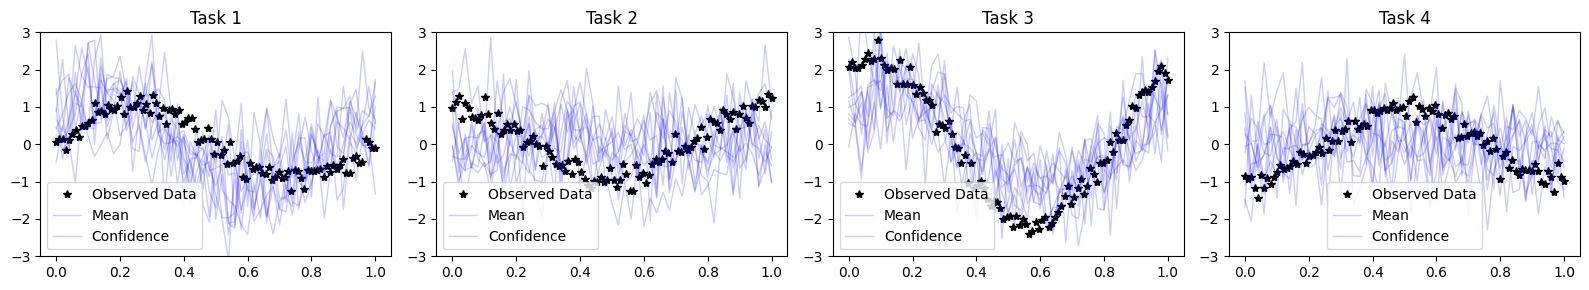

In [7]:
# Set into eval mode and make predictions
model.eval()
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51)
    predictions = model.likelihood(model(test_x)).rsample()
print(predictions.shape)  # num_samples x num_data x num_tasks
    
fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))
for task, ax in enumerate(axs):
    ax.plot(train_x.detach().numpy(), train_y[:, task].detach().numpy(), 'k*')
    ax.plot(test_x.numpy(), predictions[:, :, task].T.numpy(), 'b', lw=1, alpha=0.2)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Task {task + 1}')

fig.tight_layout()
None

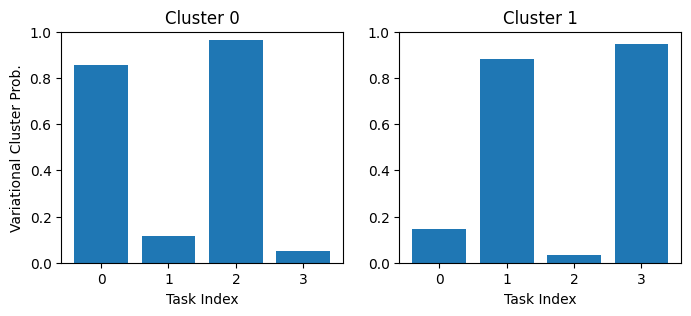

In [8]:
# Infer cluster assignments
variational_clusters = pyro.distributions.Categorical(logits=model.likelihood.variational_cluster_logits).probs

# Plot cluster assignments
fig, axs = plt.subplots(1, model.num_functions, figsize=(4 * model.num_functions, 3))
for function, ax in enumerate(axs):
    index = torch.arange(num_tasks)
    ax.bar(index, variational_clusters[:, function].detach().numpy())
    ax.set(ylim=[0, 1], title=f"Cluster {function}", xlabel="Task Index")
axs[0].set_ylabel("Variational Cluster Prob.")
None